# Limit Order Flow Imbalance and Advanced Neural Networks

By Aric Cutuli<br>
***

## Opening Remarks
The enigma concerning the predictability of markets has always been the principal driver of my interest in finance, and it inpires my ongoing exploration of machine learning's applications within the analysis of financial time series. Today, we compare the perforance of a studied deep learning model for limit order book forecasting on two stationary representations of the limit order book.


## Abstract
In this notebook, we implement an advanced neural network originally employed by (Zhang et al) that combines convolutional neural networks (CNNs) and a long-short term memory network (LSTM) in order to classify future directions of an order book at a high frequency. Specifically, given Coinbase order book data for Bitcoin, we seek to predict whether the mid price increases, decreases, or does not change in the next observation of the time series. Unlike the works of (Zhang et al), which use raw non-stationary order book states as the input to the network, our instantiation of the architecture is trained on order flow and order flow imbalance, which are stationary quantities derived from the limit order book (Cont et al). Hence, this discussion also draws heavy inspiration from a recent article (Kolm et al), which demonstrated that forecasting using order flow is a significant improvement from using raw order book inputs. Today, we further this discussion by comparing the model's forecasting performance when trained on order flow versus order flow imbalance, and we observe the model's efficacy under a pair of trading strategies.

## Order Books, Flow, and Imbalance
Today's trading of financial instruments is conducted electronically and is often facilitated by a *limit order book*, also known as an *order book*. The order book collects bids and offers made by prospective buyers and sellers and determines which incoming orders get executed and which are added to the book. The *bid price* is the highest price buyers are prepared to buy at, and the *ask price* is the lowest price sellers are willing to sell at. The *mid price*, which our model will seek to predict moves in, is the midpoint of the bid price and the ask price.

An order is defined by its side, quantity demanded, price to trade at, and time of submission. As one enters the system, the matching engine of the exchange seeks to match the order with existing orders in the book. Orders that match are executed and called *market orders*, and orders that do not match or only partially match are added to the book and called *limit orders*.

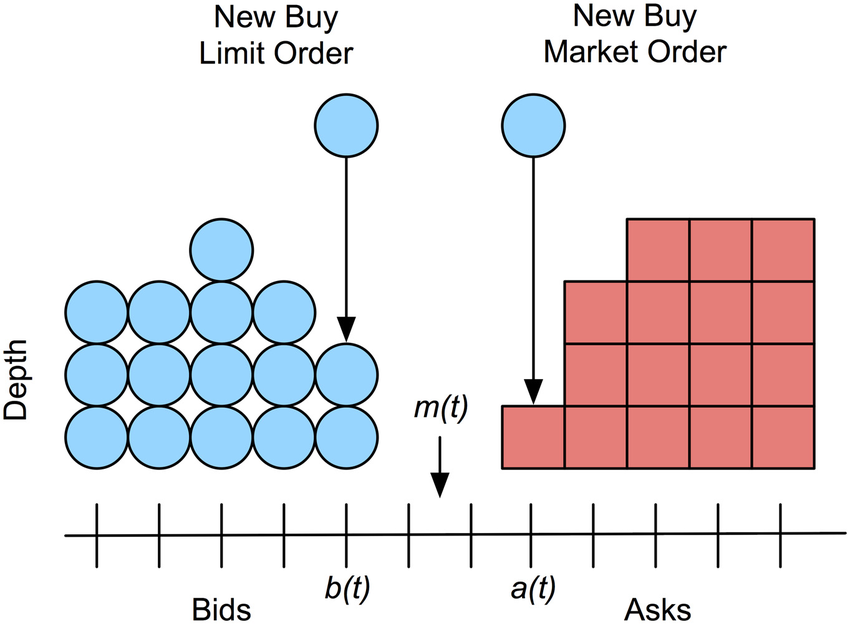

Our model takes as inputs representations of the first ten levels of the order book. A level is denoted by its price and volume that is bid or asked. So, as we progress down levels on the bid side of the order book, the price decreases, and as we progress down levels of the ask side, the price increases. Each observation in our dataset will be a 40-variable vector displaying the price and volume for each of the top ten bid and ask levels, giving us a truncated screenshot of the state of the order book at each timestep. 

$$s_t^{LOB} := (a_t^1, v_t^{1,a}, b_t^1, v_t^{1,b}, ..., a_t^10, v_t^{10,a}, b_t^10, v_t^{10,b}) \in \mathcal{R}^{40}$$

Our *bid order flows* (bOF) and *ask order flows* (aOF) at a timestamp are 10-variable vectors computed using two consecutive order book states, where each element is defined in the following manner.

$$ bOF_{t,i} :=   \left\{
\begin{array}{ll}
      v_t^{i,b}, & b_t^i > b_{t-1}^i \\
      v_t^{i,b} - v_{t-1}^{i,b}, & b_t^i = b_{t-1}^i \\
      -v_t^{i,b}, & b_t^i < b_{t-1}^i \\
\end{array} 
\right.  $$
$$ aOF_{t,i} :=   \left\{
\begin{array}{ll}
      -v_t^{i,a}, & a_t^i > a_{t-1}^i \\
      v_t^{i,a} - v_{t-1}^{i,a}, & a_t^i = a_{t-1}^i \\
      v_t^{i,a}, & a_t^i < a_{t-1}^i \\
\end{array} 
\right.  $$

## The Model

Producing a forecast is simply a matter of taking the conditional expectation of the data under the model.

Feature extraction of microstructure data has generically been handled with PCA or LDA, but here we adopt CNNs and Inception Modules to accomplish this task.

CNNs are used to automate the feature extraction process instead of feature engineering and PCA. (Zhang et al)

CNNs attempt to reduce the network size by exploiting data locality (Dixon + Halperin)

in financial modeling, we typically have different spatial structures, such as the limit order book depths

Inception module increases width and depth of the convolutions, hence helps capture local interactions bewtween timestamps. (Szegedy et al) Infer decay rates of the autoregressive process. (Zhang et al)

## Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
# from cbpro import PublicClient
# from time import time, strftime, gmtime

In [4]:
# public_client = PublicClient()
# dataframe = pd.DataFrame()
# start = time()
# while len(dataframe) < 100002:
#     raw_data = pd.concat((pd.DataFrame.from_dict(public_client.get_product_order_book('BTC-USD',level=2)['asks'])[:10],
#                      pd.DataFrame.from_dict(public_client.get_product_order_book('BTC-USD',level=2)['bids'])[:10]),axis=1)
#     dataframe = pd.concat((dataframe, pd.concat((pd.DataFrame(raw_data.drop(2,axis=1).iloc[i]).T for i in range(10)), axis=1).apply(lambda x: pd.Series(x.dropna().values))))
# end = time()
# print((end-start)/len(dataframe))

0.7216747066254201


In [7]:
# dataframe.columns = ['PRICE_ASK_0','VOLUME_ASK_0','PRICE_BID_0','VOLUME_BID_0',
#            'PRICE_ASK_1','VOLUME_ASK_1','PRICE_BID_1','VOLUME_BID_1',
#            'PRICE_ASK_2','VOLUME_ASK_2','PRICE_BID_2','VOLUME_BID_2',
#            'PRICE_ASK_3','VOLUME_ASK_3','PRICE_BID_3','VOLUME_BID_3',
#            'PRICE_ASK_4','VOLUME_ASK_4','PRICE_BID_4','VOLUME_BID_4',
#            'PRICE_ASK_5','VOLUME_ASK_5','PRICE_BID_5','VOLUME_BID_5',
#            'PRICE_ASK_6','VOLUME_ASK_6','PRICE_BID_6','VOLUME_BID_6',
#            'PRICE_ASK_7','VOLUME_ASK_7','PRICE_BID_7','VOLUME_BID_7',
#            'PRICE_ASK_8','VOLUME_ASK_8','PRICE_BID_8','VOLUME_BID_8',
#            'PRICE_ASK_9','VOLUME_ASK_9','PRICE_BID_9','VOLUME_BID_9']
# dataframe.index = range(len(dataframe))
# dataframe = dataframe.astype(float)
# dataframe

In the spirit of the FI-2010 dataset, we extract labels based on short-term
and long-term, event-based, relative changes for the next 1, 2, 3, 5, and 10
midpoints in the order book dataset. However, in lieu of comparable granularity in our dataset, we simply label relative changes for nly the next event.

Our labels describe the percentage change of the mid-price

The extracted labels are based
on a threshold for the percentage change of 0.002. For percentage changes equal
to or greater than 0.002, we use label 1. For percentage change that varies from
-0.00199 to 0.00199, we use label 0, and, for percentage change smaller or equal
to -0.002, we use label -1.

In [8]:
# dataframe['LABEL_1TICK'] = np.zeros(len(dataframe))
# for i in range(len(dataframe)-1):
#     if (dataframe.loc[i+1,'PRICE_ASK_0'] + dataframe.loc[i+1,'PRICE_ASK_0']) > 1.00002*(dataframe.loc[i,'PRICE_ASK_0'] + dataframe.loc[i,'PRICE_ASK_0']):
#         dataframe['LABEL_1TICK'][i] = 1
#     elif (dataframe.loc[i+1,'PRICE_BID_0'] + dataframe.loc[i+1,'PRICE_BID_0']) < 0.99998*(dataframe.loc[i,'PRICE_BID_0'] + dataframe.loc[i,'PRICE_BID_0']):
#         dataframe['LABEL_1TICK'][i] = -1
# dataframe = dataframe.head(len(dataframe)-1)

In [10]:
# dataframe.to_csv('BTC-USD LOB {}'.format(strftime('%d %b %Y', gmtime())), index=False)

In [3]:
dataframe = pd.read_csv('BTC-USD LOB 24 Jun 2022')
dataframe

,PRICE_ASK_0,VOLUME_ASK_0,PRICE_BID_0,VOLUME_BID_0,PRICE_ASK_1,VOLUME_ASK_1,PRICE_BID_1,VOLUME_BID_1,PRICE_ASK_2,VOLUME_ASK_2,...,VOLUME_BID_7,PRICE_ASK_8,VOLUME_ASK_8,PRICE_BID_8,VOLUME_BID_8,PRICE_ASK_9,VOLUME_ASK_9,PRICE_BID_9,VOLUME_BID_9,LABEL_1TICK
0,20690.00,0.084309,20689.99,0.011289,20690.02,0.000143,20689.98,0.000348,20691.38,0.981250,...,0.000300,20695.72,0.100000,20685.97,0.003401,20696.33,0.358238,20685.65,0.002158,0.0
1,20690.00,0.084309,20689.99,0.011289,20690.02,0.000143,20689.98,0.000348,20691.38,0.981250,...,0.000300,20695.72,0.100000,20685.97,0.003401,20696.33,0.358238,20685.65,0.002158,0.0
2,20690.00,0.084309,20689.99,0.011289,20690.02,0.000143,20689.98,0.000348,20691.38,0.981250,...,0.000300,20695.72,0.100000,20685.97,0.003401,20696.33,0.358238,20685.65,0.002158,0.0
3,20690.00,0.084309,20689.65,0.005000,20690.02,0.000143,20689.64,0.006213,20691.38,0.981250,...,0.150000,20695.72,0.100000,20685.57,2.043200,20696.33,0.358238,20685.32,0.018317,0.0
4,20689.88,0.017278,20689.83,0.011799,20689.89,0.000100,20686.69,0.003841,20689.90,0.000100,...,0.024724,20692.00,0.231488,20682.78,0.025542,20693.47,0.016210,20682.10,0.241633,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,21076.00,0.020025,21072.72,0.002722,21076.08,0.025441,21072.71,0.091130,21076.14,0.020467,...,0.018979,21078.66,0.008612,21071.74,0.227235,21078.72,0.227227,21071.32,0.100000,-1.0
99997,21071.31,0.005324,21068.78,0.094586,21071.35,0.013313,21068.65,0.080000,21071.41,0.005000,...,0.237270,21073.46,0.013086,21066.24,0.120000,21073.48,0.021072,21065.65,0.355873,0.0
99998,21071.31,0.005324,21068.78,0.094586,21071.35,0.013313,21068.65,0.080000,21071.41,0.005000,...,0.237270,21073.46,0.013086,21066.24,0.120000,21073.48,0.021072,21065.65,0.355873,-1.0
99999,21064.51,0.111293,21064.50,0.005000,21064.60,0.041741,21061.10,0.744450,21065.25,0.008726,...,0.355963,21066.80,0.009655,21058.89,0.004937,21067.00,0.227349,21057.91,0.098579,-1.0


For our cryptocurrency, we let t ∈ {1, . . . , T } denote an enumeration of all order book updates. Given two consecutive order book states for the cryptocurrency at t − 1 and t, we define the bid order flows and ask order flows at time t as vectors

In [10]:
of_data = pd.DataFrame()
for i in range(10):
    of_data['bOF_{}'.format(i)] = np.empty(len(dataframe))
    of_data['aOF_{}'.format(i)] = np.empty(len(dataframe))
    of_data['bOF_{}'.format(i)][0] = None
    of_data['aOF_{}'.format(i)][0] = None
    for j in range(1,len(dataframe)):
            
        # Bid Order Flow
        if dataframe.loc[j,'PRICE_BID_{}'.format(i)] > dataframe.loc[j-1,'PRICE_BID_{}'.format(i)]:
            of_data['bOF_{}'.format(i)][j] = dataframe.loc[j,'VOLUME_BID_{}'.format(i)]
        elif dataframe.loc[j,'PRICE_BID_{}'.format(i)] < dataframe.loc[j-1,'PRICE_BID_{}'.format(i)]:
            of_data['bOF_{}'.format(i)][j] = -1*dataframe.loc[j,'VOLUME_BID_{}'.format(i)]
        else:
            of_data['bOF_{}'.format(i)][j] = dataframe.loc[j,'VOLUME_BID_{}'.format(i)] - dataframe.loc[j-1,'VOLUME_BID_{}'.format(i)]
            
        # Ask Order Flow
        if dataframe.loc[j,'PRICE_ASK_{}'.format(i)] > dataframe.loc[j-1,'PRICE_ASK_{}'.format(i)]:
            of_data['aOF_{}'.format(i)][j] = -1*dataframe.loc[j,'VOLUME_ASK_{}'.format(i)]
        elif dataframe.loc[j,'PRICE_ASK_{}'.format(i)] < dataframe.loc[j-1,'PRICE_ASK_{}'.format(i)]:
            of_data['aOF_{}'.format(i)][j] = dataframe.loc[j,'VOLUME_ASK_{}'.format(i)]
        else:
            of_data['aOF_{}'.format(i)][j] = dataframe.loc[j,'VOLUME_ASK_{}'.format(i)] - dataframe.loc[j-1,'VOLUME_ASK_{}'.format(i)]

In [11]:
# Add output columns to of_data
of_data = pd.concat([of_data,dataframe.iloc[:,-1:]],axis=1)

In [12]:
# Drop first row
of_data = of_data.iloc[1:,:]

In [13]:
of_data

,bOF_0,aOF_0,bOF_1,aOF_1,bOF_2,aOF_2,bOF_3,aOF_3,bOF_4,aOF_4,...,aOF_5,bOF_6,aOF_6,bOF_7,aOF_7,bOF_8,aOF_8,bOF_9,aOF_9,LABEL_1TICK
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,-0.005000,0.000000,-0.006213,0.000000,-0.003067,0.000000,-0.009612,0.000000,-0.000300,0.000000,...,0.000000,-0.002158,0.000000,-0.150000,0.000000,-2.043200,0.000000,-0.018317,0.000000,0.0
4,0.011799,0.017278,-0.003841,0.000100,-1.513803,0.000100,-0.018317,0.000100,-0.100000,0.006624,...,0.057827,-0.016070,0.000143,-0.024724,0.981250,-0.025542,0.231488,-0.241633,0.016210,0.0
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0
99997,-0.094586,0.005324,-0.080000,0.013313,-0.227265,0.005000,-0.339581,0.006926,-0.000495,0.016311,...,0.016860,-0.010967,0.238264,-0.237270,0.061199,-0.120000,0.013086,-0.355873,0.021072,0.0
99998,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0
99999,-0.005000,0.111293,-0.744450,0.041741,-0.007445,0.008726,-1.085000,0.044998,-0.050000,0.227351,...,0.052319,-0.006386,0.007704,-0.355963,0.637379,-0.004937,0.009655,-0.098579,0.227349,-1.0


## Methodology

### Analyzing Stationarity

Staionary time series is one such that its statistical parameters such as mean and variance do not change over time. If the linear combination or spread of two time series is stationary, then the two variables are said to be cointegrated. That is, for two time series, if the spread stays around the mean, then the variables are said to be cointegrated. Correlated time series, on the other hand, refer to variables whose movements are typically in the same direction, but their spread in nonstationary.

What's the importance of stationarity?

We firstly determine the stationarity for our multivariate time series by performing the Johansen's cointegration test. (Johansen) We do not utilize the Augmented Dickey Fuller (ADF) test for each univariate time series in our data, since we are not interested in the stationarity of each variable in a multivariate time series. As mentioned previously, however, we understand that order flow and volume are univariately stationary (Cont et al).

The null hypothesis for Johansen's cointegration test with trace is that the number of cointegrating relationships is less than the number of variables in our time series, while the alternative is that the number of cointegrating relationships equals the number of variables in our time series. By rejecting the null hypothesis at a specified significance level, we accept that the multivariate time series is stationary with that significance. We choose to perform the test at the 99% significance level.

However, there is a key caveat in our specific usage of Johansen's cointegration test that cannot be overlooked, which is the fact that computing critical values for a multivariate time series of more than 12 variables cannot be done with this test, so we cannot directly apply this test on our 20-variable time series since the result can hence not be used to deduce the cointegrating relationships in the time series. 

We can, however, test for stationary on our order book data's order flow imbalance, which differences the bid and ask order flows for each respective level in the order book. This differencing leaves us with a 10-variable dataset that we can deduce the stationarity of and continue with our modeling process.

In [17]:
ofi_data = pd.DataFrame()
for i in range(10):
    ofi_data['OFI_{}'.format(i)] = np.empty(len(of_data))
    for j in range(len(of_data)):
        ofi_data['OFI_{}'.format(i)][j] = of_data.loc[j+1,'bOF_{}'.format(i)] - of_data.loc[j+1,'aOF_{}'.format(i)]


In [18]:
ofi_data = pd.concat([ofi_data,of_data.iloc[:,-1:]],axis=1).apply(lambda x: pd.Series(x.dropna().values))

In [19]:
ofi_data

,OFI_0,OFI_1,OFI_2,OFI_3,OFI_4,OFI_5,OFI_6,OFI_7,OFI_8,OFI_9,LABEL_1TICK
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,-0.005000,-0.006213,-0.003067,-0.009612,-0.000300,-0.003401,-0.002158,-0.150000,-2.043200,-0.018317,0.0
3,-0.005478,-0.003941,-1.513903,-0.018417,-0.106624,-0.807827,-0.016213,-1.005974,-0.257030,-0.257842,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
99995,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0
99996,-0.099911,-0.093313,-0.232265,-0.346507,-0.016806,-0.766860,-0.249231,-0.298469,-0.133086,-0.376945,0.0
99997,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.0
99998,-0.116293,-0.786191,-0.016171,-1.129998,-0.277351,-0.289645,-0.014090,-0.993342,-0.014593,-0.325928,-1.0


In [80]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

In [81]:
jres = coint_johansen(ofi_data.iloc[:,:-1], det_order=0, k_ar_diff=1)

In [82]:
jres.trace_stat > jres.trace_stat_crit_vals[:,2]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

The generated trace statistics and are far greater than the critical values at the 99% significance level, so we can reject the null hypothesis at the 99% significance level. That is, we are at least 99% confident that the number of cointegrating relationships is equal to the number of variables in our multivariate time series, so we consider the multivariate time series data to be stationary.

### Remark on Autocorrelation

Classically, the order of the autoregressive process is what we use to control the lag parameter of the deep learning model. For a univariate model, this can be determined from the time series data with a partial autocorrelation test. However, for a multivariate model such as ours, the estimation process is different since we must account for the cross-correlations between the 20 variables.

Now, the articles from which we adopt the deep learning model offer a lag parameter of 100 timestamps. However, the mean squared error of a 1-step ahead prediction increases with respect to the order of the autoregressive process, so we choose to estimate the order statistically and select it as our window length. We can do so on the basis that if a process has order *p*, then it has order *p+1*.

The `VAR` class of the `statsmodels` package assumes that the passed time series are stationary, so we can use it for our estimation of the order of our process.

Choice of lag order can be a difficult problem. Standard analysis employs likelihood test or information criteria-based order selection.

Pros and cons of increasing/decreasing lag parameter?

In [15]:
from statsmodels.tsa.api import VAR

/Users/ajcutuli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
/Users/ajcutuli/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [20]:
model = VAR(ofi_data.iloc[:,:-1])
results = model.fit(maxlags=100, ic='aic')
lag_order = results.k_ar
print(lag_order)

76


### Splitting the Time Series

We split the training and test set by using the first 80% of the time series and the remaining 20% for the test set. Note that the test set must be in the future of the training set to avoid look-ahead bias.

In [22]:
# Train test split
train_weight = 0.8
ofi_train, ofi_test = np.array([None]), np.array([None])
ofi_train = ofi_data.iloc[:int(len(ofi_data)*train_weight)]
ofi_test = ofi_data.iloc[int(len(ofi_data)*train_weight):]

### Scaling

Standardization of the data is important to avoid potential scaling difficulties in the fitting of the model. When there is more than one feature (covariate), scaling avoids one feature dominating over another due to disparate scales.

To avoid introducing a look-ahead bias into the prediction, we must re-scale the training data without knowledge of the test set. Hence, we will simply standardize the training set using the mean and standard deviation of the training set and not the whole time series. Additionally, to avoid introducing a systematic bias into test set, we use the identical normalization for the test set - the mean and standard deviation of the training set are used to normalize the test set.

In [23]:
# Standardize data
# note that for a multivariate time series, you would need to scale 
# each variable by its own mean and standard deviation in the training set
for col in ofi_train.columns[:-1]:
    mu = np.float(ofi_train.loc[:,col].mean())
    sigma = np.float(ofi_train.loc[:,col].std())
    stdize_input = lambda x: (x - mu) / sigma
    ofi_train[col] = ofi_train.loc[:,col].apply(stdize_input)
    ofi_test[col] = ofi_test.loc[:,col].apply(stdize_input)

<ipython-input-23-7f8ae83af7c1>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ofi_train[col] = ofi_train.loc[:,col].apply(stdize_input)
<ipython-input-23-7f8ae83af7c1>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ofi_test[col] = ofi_test.loc[:,col].apply(stdize_input)


### Data Formatting

To perform our sequential learning task, we must tensorize our data to create a time series that will serve as the inputs to the network.

Let's define the following function for reshaping the data into a return prediction format for the 5 time horizons of the original set.

In [24]:
# ready data for training:
# 1. sample_size=lag_order: the most recent lag_order updates, number of lags, i.e. sequence length
# 2. feature_num=10: 10 features per time stamp, number of variables in the series
# 3. target_num=1: relative change for the next event, number of forecasting horizons
def get_lagged_features(data, sample_size=lag_order, feature_num=10, target_num=1):
    data = data.values
    shape = data.shape
    X = np.zeros((shape[0]-sample_size, sample_size, feature_num))
    Y = np.zeros(shape=(shape[0]-sample_size, target_num))
    for i in range(shape[0]-sample_size):
        X[i] = data[i:i+sample_size,:feature_num] # take the first 20 columns as features
        Y[i] = data[i+sample_size-1,-target_num:] # take the last column as labels
    X = X.reshape(X.shape[0], sample_size, feature_num, 1) # add the 4th dimension: 1 channel
    
    # "Benchmark dataset for mid-price forecasting of limit order book data with machine learning"
    # label 1: change greater or equal to 0.002%
    # label 0: change within -0.00199% to 0.00199%
    # label -1: change smaller or equal to -0.002%
    # Y+=1 relabels as 0,1,2
    Y += 1
    return X,Y

In [25]:
train_X, train_Y = get_lagged_features(ofi_train)
train_Y = train_Y.astype(int)

In [26]:
print(train_X.shape)

(79924, 76, 10, 1)


In [27]:
train_Y.shape

(79924, 1)

### Model Specification

In [28]:
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model
import keras.initializers
from tensorflow.keras.layers import Dropout
import tensorflow as tf

In [29]:
def CNN_LSTM(dropout = 0.2, seed = 0):
    # the size of a single input is (lag_order,10). Note that we statistically generated a lag order of 15.
    input_tensor = Input(shape=(lag_order,10,1))

    # convolutional filter is (1,2) with stride of (1,2)
    layer_x = layers.Conv2D(16, (4,1), padding='same', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed))(input_tensor)
    layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)
    layer_x = layers.Conv2D(16, (4,1), padding='same', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed))(layer_x)
    layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)

    layer_x = layers.Conv2D(16, (1,10), kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed))(layer_x)
    layer_x = layers.LeakyReLU(alpha=0.01)(layer_x)

    # Inception Module
    tower_1 = layers.Conv2D(32, (1,1), padding='same', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed))(layer_x)
    tower_1 = layers.LeakyReLU(alpha=0.01)(tower_1)
    tower_1 = layers.Conv2D(32, (3,1), padding='same', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed))(tower_1)
    tower_1 = layers.LeakyReLU(alpha=0.01)(tower_1)

    tower_2 = layers.Conv2D(32, (1,1), padding='same', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed))(layer_x)
    tower_2 = layers.LeakyReLU(alpha=0.01)(tower_2)
    tower_2 = layers.Conv2D(32, (5,1), padding='same', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed))(tower_2)
    tower_2 = layers.LeakyReLU(alpha=0.01)(tower_2)  

    tower_3 = layers.MaxPooling2D((3,1), padding='same', strides=(1,1))(layer_x)
    tower_3 = layers.Conv2D(32, (1,1), padding='same', kernel_initializer=keras.initializers.glorot_uniform(seed), bias_initializer=keras.initializers.glorot_uniform(seed))(tower_3)
    tower_3 = layers.LeakyReLU(alpha=0.01, )(tower_3)

    layer_x = layers.concatenate([tower_1, tower_2, tower_3], axis=-1)

    # concatenate features of tower_1, tower_2, tower_3
    layer_x = layers.Reshape((lag_order,96))(layer_x)
    
    # insert dropout layer
    layer_x = Dropout(dropout)(layer_x)
    
    # 64 LSTM units
    layer_x = LSTM(64, kernel_initializer=keras.initializers.glorot_uniform(0), bias_initializer=keras.initializers.glorot_uniform(0), recurrent_initializer=keras.initializers.orthogonal(0))(layer_x)
    # The last output layer uses a softmax activation function
    output = layers.Dense(3, activation='softmax', kernel_initializer=keras.initializers.glorot_uniform(0), bias_initializer=keras.initializers.glorot_uniform(0))(layer_x)
    model = Model(input_tensor, output)
    opt = tf.keras.optimizers.Adam(learning_rate=0.01, epsilon=1) # learning rate and epsilon are the same as paper DeepLOB
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
       

In [30]:
model_params = {
    'model': None, 'function': CNN_LSTM, 'dropout': 0.2, 'label': 'CNN_LSTM'
}

### Cross-validation

any model that has been fitted under a Box–Jenkins approach needs to be assessed out-of-sample by time series cross-validation

As advocated for in BDLOB, we utilize dropout variational inference as a stochastic regularizer in the deep neural network. We use grid search to detect an appropriate dropout rate. We insert this dropout layer after the Inception Module.

We apply early stopping for all models to avoid overfitting, terminating training when validation loss has not decreased for five consecutive epochs.

In the time series model, observations are strongly related to their recent histories. Hence, the ordering of our data matters, so we can't apply the typical K-fold cross-validation that is applied in cross-sectional models. In prediction models over time series data, no future observations can be used in the training set. Instead, a sliding window must be used to train and predict out-of-sample over multiple repetitions to allow for parameter tuning

Do we fix the length of the sliding training window or do we allow it to "telescope" in time? There are pros and cons to choosing the latter; it includes more observations for training, but parameter confidence loses interpretability due to the loss of sample size control.

In [31]:
from keras.callbacks import EarlyStopping

In [32]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5, min_delta=3e-5, restore_best_weights=True)

In [33]:
from sklearn.model_selection import KFold, TimeSeriesSplit, GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.utils import to_categorical

In [34]:
max_epochs = 100
batch_size = 32

In [35]:
# dropout = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    
# # A dictionary containing a list of values to be iterated through
# # for each parameter of the model included in the search
# param_grid = {'dropout': dropout}
    
# # In the kth split, TimeSeriesSplit returns first k folds
# # as training set and the (k+1)th fold as test set.
# tscv = TimeSeriesSplit(n_splits = 5)
    
# # A grid search is performed for each of the models, and the parameter set which
# # performs best over all the cross-validation splits is saved in the `params` dictionary

# model = KerasRegressor(build_fn=model_params['function'], epochs=max_epochs, 
#                         batch_size=batch_size, verbose=2)
# grid = GridSearchCV(estimator=model, param_grid=param_grid, 
#                     cv=tscv, n_jobs=1, verbose=1)
# train_Y = to_categorical(train_Y) # y is the next event's mid price (k=1)
# grid_result = grid.fit(train_X, train_Y, callbacks=[es])
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params_ = grid_result.cv_results_['params']
# for mean, stdev, param_ in zip(means, stds, params_):
#     print("%f (%f) with %r" % (mean, stdev, param_))

#     model_params['dropout'] = grid_result.best_params_['dropout']

### Training the Model

#### 1-step Prediction

In [104]:
model = model_params['function'](dropout = model_params['dropout'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 76, 10, 1)]  0           []                               
                                                                                                  
 conv2d_15 (Conv2D)             (None, 76, 10, 16)   80          ['input_3[0][0]']                
                                                                                                  
 leaky_re_lu_14 (LeakyReLU)     (None, 76, 10, 16)   0           ['conv2d_15[0][0]']              
                                                                                                  
 conv2d_16 (Conv2D)             (None, 76, 10, 16)   1040        ['leaky_re_lu_14[0][0]']         
                                                                                            

In [105]:
# train_Y = to_categorical(train_Y) # y is the next event's mid price (k=1)
# model.fit(train_X, train_Y, epochs=max_epochs, batch_size=batch_size, callbacks=[es])
# model_params['model'] = model

Epoch 1/100
2498/2498 [==============================] - 199s 78ms/step - loss: 0.7692 - accuracy: 0.7287
Epoch 2/100
2498/2498 [==============================] - 189s 76ms/step - loss: 0.7617 - accuracy: 0.7344
Epoch 3/100
2498/2498 [==============================] - 189s 76ms/step - loss: 0.7560 - accuracy: 0.7344
Epoch 4/100
2498/2498 [==============================] - 189s 76ms/step - loss: 0.7242 - accuracy: 0.7344
Epoch 5/100
2498/2498 [==============================] - 190s 76ms/step - loss: 0.6617 - accuracy: 0.7333
Epoch 6/100
2498/2498 [==============================] - 190s 76ms/step - loss: 0.6451 - accuracy: 0.7332
Epoch 7/100
2498/2498 [==============================] - 186s 75ms/step - loss: 0.6368 - accuracy: 0.7339
Epoch 8/100
2498/2498 [==============================] - 176s 70ms/step - loss: 0.6293 - accuracy: 0.7348
Epoch 9/100
2498/2498 [==============================] - 176s 70ms/step - loss: 0.6230 - accuracy: 0.7350
Epoch 10/100
2498/2498 [======================

In [107]:
# model_params['model'].save('CNN-LSTM-SAVED.hdf5', overwrite=True)  # creates a HDF5 file

In [36]:
from keras.models import load_model
model_params['model'] = load_model('CNN-LSTM-SAVED.hdf5')

Evaluation metrics for the model

In [38]:
test_X, test_Y = get_lagged_features(ofi_test)
test_Y = test_Y.astype(int)

test_Y = to_categorical(test_Y)
model_params['model'].evaluate(test_X, test_Y)

623/623 [==============================] - 23s 34ms/step - loss: 0.7190 - accuracy: 0.6878


[0.7190269827842712, 0.6878136992454529]

In [39]:
model_params['pred_test'] = model_params['model'].predict(test_X, verbose=1) 

623/623 [==============================] - 23s 35ms/step


In [42]:
model_params['pred_test']

array([[0.45513463, 0.31783095, 0.22703438],
       [0.0062182 , 0.9849231 , 0.00885864],
       [0.47333342, 0.33191097, 0.1947556 ],
       ...,
       [0.00974436, 0.9790339 , 0.0112218 ],
       [0.38841417, 0.49786842, 0.11371739],
       [0.00994822, 0.97791284, 0.0121389 ]], dtype=float32)

In [55]:
pred_Y = np.zeros(test_Y.shape)
for i in range(len(test_Y)):
    pred_Y[i,np.argmax(model_params['pred_test'][i])] = 1
    

Classification report

In [87]:
from sklearn.metrics import classification_report
print(classification_report(test_Y, pred_Y, target_names=['Down', 'Stationary', 'Up']))

              precision    recall  f1-score   support

        Down       0.38      0.43      0.41      3542
  Stationary       0.80      0.86      0.83     12733
          Up       0.55      0.33      0.41      3649

   micro avg       0.69      0.69      0.69     19924
   macro avg       0.58      0.54      0.55     19924
weighted avg       0.68      0.69      0.68     19924
 samples avg       0.69      0.69      0.69     19924



Confusion matrix for the model

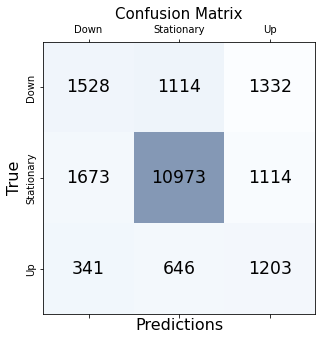

In [85]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

mat_con = confusion_matrix(test_Y.argmax(axis=1), pred_Y.argmax(axis=1))

fig, px = plt.subplots(figsize=(5,5))
px.matshow(mat_con, cmap=plt.cm.Blues, alpha=0.5)

for m in range(mat_con.shape[0]):
    for n in range(mat_con.shape[1]):
        px.text(x=m, y=n, s=mat_con[m, n], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=16)
plt.ylabel('True', fontsize=16)
plt.xticks(np.arange(3), ['Down', 'Stationary', 'Up'])
plt.yticks(np.arange(3), ['Down', 'Stationary', 'Up'], rotation='vertical', va='center')
plt.title('Confusion Matrix', fontsize=15)
plt.show()

## Building a Trading Signal

Now, is there a profitable trading strategy utilizing this model? How risky is it?

To answer this, we compare two trading strategies using our test set as the trading period.

We trade the midpoint of the limit order book, so let's create a vector of the true midpoints we trade.

In [64]:
test_midpoints = (dataframe.iloc[1+int(len(ofi_data)*train_weight):]['PRICE_ASK_0'] + dataframe.iloc[1+int(len(ofi_data)*train_weight):]['PRICE_BID_0']) / 2

### Softmax Trading Strategy

For this strategy, we choose a threshold probability $\alpha$ and go long if $p_{+1,t}>\alpha$ and go short if $p_{-1,t}>\alpha$.

In [79]:
threshold = 0.8
position = None
entry_last = None
pnl = 0
num_trades = 0
for i in range(len(model_params['pred_test'])):
    if position != 'LONG' and np.argmax(model_params['pred_test'][i]) == 2 and np.max(model_params['pred_test'][i]) > threshold:
        # Go long
        position = 'LONG'
        entry_now = test_midpoints.iloc[i]
        if entry_last != None:
            pnl += entry_now - entry_last
        entry_last = entry_now
        num_trades += 1
    if position != 'SHORT' and np.argmax(model_params['pred_test'][i]) == 0 and np.max(model_params['pred_test'][i]) > threshold:
        # Go long
        position = 'SHORT'
        entry_now = test_midpoints.iloc[i]
        if entry_last != None:
            pnl += entry_last - entry_now
        entry_last = entry_now
        num_trades += 1
print(pnl, num_trades)

112.7950000000128 5


### Bayesian Trading Strategy

This strategy uses variational ratios, predictive entropy, and mutual information to summarize classification uncertainty due to variational dropout.

### Results

## Shortfalls of Deep Learning

Deep neural networks as a "black box"

"Offline" version of learning

## Conclusion

## References

[1] Zhang, Zihao, Stefan Zohren, and Stephen Roberts (2019). “DeepLOB: Deep Convolutional Neural Networks for Limit Order Books”. In: *IEEE Transactions On Signal Processing* 67.11, pp. 3001–3012.<br>
[2] Cont, Rama, Arseniy Kukanov, and Sasha Stoikov (2014). “The Price Impact Of
Order Book Events”. In: *Journal Of Financial Econometrics* 12.1, pp. 47–88.<br>
[3] Kolm, Petter, Jeremy Turiel, and Nicholas Westray (2021). "Deep Order Flow Imbalance: Extracting Alpha At Multiple Horizons From The Limit Order Book". In: *Available at SSRN 3900141*.<br>
[] Ntakaris, Adamantios, Martin Magris, Juho Kanniainen, Moncef Gabbouj, and Alexandros Iosifidis (2018). “Benchmark Dataset For Mid-Price Forecasting Of Limit Order Book Data With Machine Learning Methods”. In: *Journal of Forecasting* 37.8, pp. 852–866.<br>
[] Szegedy, Christian, Wei Liu, Yangqing Jia, Pierre Sermanet, Scott Reed, Dragomir Anguelov, Dumitru Erhan, Vincent Vanhoucke, and Andrew Rabinovich (2015). “Going Deeper With Convolutions”. In: *Proceedings Of The IEEE Conference On Computer Vision And Pattern Recognition*, pp. 1–9.<br>
[] Zhang, Zihao, Stefan Zohren, and Stephen Roberts (2018). “BDLOB: Bayesian Deep Convolutional Neural Networks For Limit Order Books”. In: *arXiv preprint arXiv:1811.10041*.<br>
[] Dixon, Matthew F., Igor Halperin, and Paul Bilokon (2020). *Machine Learning in Finance: From Theory to Practice*. Springer.<br>
[] Tsay, Ruey S. (2010). *Analysis of Financial Time Series* (3rd ed.). Wiley.<br>
[] Lütkepohl, Helmut (2005). *New Introduction to Multiple Time Series Analysis*. Springer.<br> 
[] Yang, Kiyoung, and Cyrus Shahabi (2005). "On the Stationarity of Multivariate Time Series for Correlation-Based Data Analysis". In: *Fifth IEEE International Conference on Data Mining*, pp. 1-4.<br>
[] Johansen, Søren (1995). *Likelihood-Based Inference in Cointegrated Vector Autoregressive Models*. Oxford University Press.<br>